<a href="https://colab.research.google.com/github/capofwesh20/Masters-Thesis/blob/main/Final_Thesis_Image_Generation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import os
import ipywidgets as widgets
import random
from IPython.display import display
from PIL import Image, ImageOps
import plotly.graph_objects as go
import glob
import ipywidgets as widgets
import random
from scipy.signal import convolve

Train Images are 1000 MNIST data

They can be found [here](https://drive.google.com/file/d/1mDTwE38Zeoj7ihl5hns0qlTcZHZbTG0E/view?usp=sharing)

In [ ]:
mat = scipy.io.loadmat('/content/train_binary.mat')
train_images = mat['train_images']
# Access the first array within 'train_images'
first_array = mat['train_images']

# Print the shape of the first array
print(first_array.shape)


(32, 32, 1000)


IRF

The IRF files can be found [here](https://drive.google.com/drive/folders/1f-rbhx0ZI-GPKzcNTDFb8xv9acpCgxll?usp=sharing)


In [ ]:

path_to_files = '/content/drive/MyDrive/SCC74A_Image_Export_irf/*irf*.npy'

file_paths = glob.glob(path_to_files)


if file_paths:  # Check if any files were found
    sum_array = np.load(file_paths[0])

    # Loop through the remaining files and accumulate the sum
    for file_path in file_paths[1:]:
        sum_array += np.load(file_path)


    control = sum_array / len(file_paths)

    # Now, mean_irf contains the mean of all the .npy files
    np.save('control_irf.npy', control)
    print("Mean irf calculated successfully.")
else:
    print("No '.npy' files containing 'irf' found at the specified location.")


Mean irf calculated successfully.


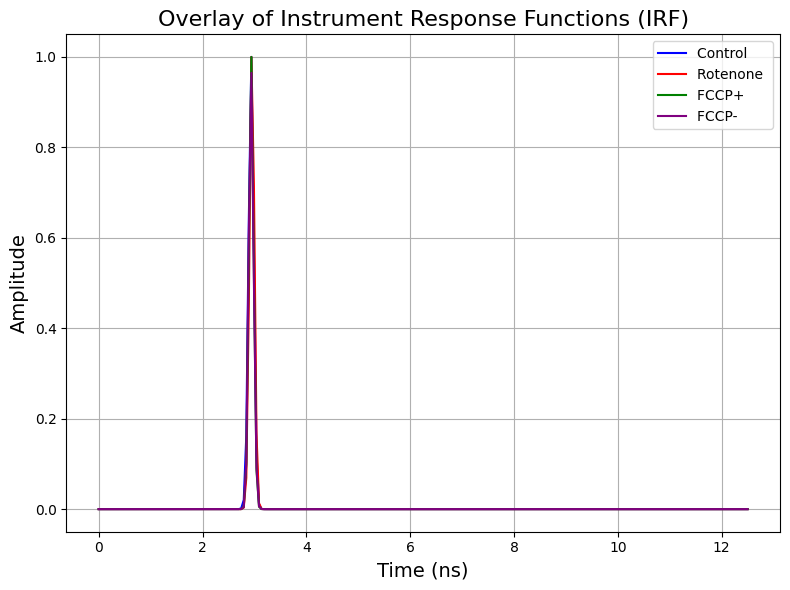

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the uploaded .npy files
control_irf = np.load('/content/control_irf.npy')
rot_irf = np.load('/content/rot_irf.npy')
fccp_irf = np.load('/content/fccp_irf.npy')
fcc_irf = np.load('/content/fcc_irf.npy')

# Define the time axis from 0 to 12.5 ns
time_ns = np.linspace(0, 12.5, len(control_irf))

# Plot the overlay of the 4 IRFs
plt.figure(figsize=(8, 6))
plt.plot(time_ns, control_irf, label='Control ', color='blue')
plt.plot(time_ns, rot_irf, label='Rotenone ', color='red')
plt.plot(time_ns, fcc_irf, label='FCCP+ ', color='green')
plt.plot(time_ns, fccp_irf, label='FCCP- ', color='purple')

# Add plot details
plt.title('Overlay of Instrument Response Functions (IRF)', fontsize = 16)
plt.xlabel('Time (ns)', fontsize = 14)
plt.ylabel('Amplitude', fontsize = 14)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:

# Create the plot with plotly
time_axis_exp = np.arange(0, 256, 1)
fig = go.Figure(data=go.Scatter(x=time_axis_exp, y=mean_irf, mode='lines'))
fig.update_layout(title='Mean IRF',
                  xaxis_title='Time Gate',
                  yaxis_title='Amplitude',
                  hovermode='x')
fig.show()


Text(0.5, 1.0, 'Mean IRF')

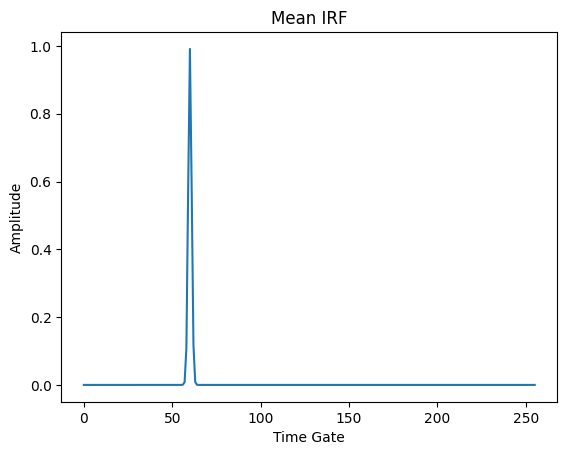

In [ ]:
plt.figure()
plt.plot(mean_irf)
plt.xlabel('Time Gate')
plt.ylabel('Amplitude')
plt.title(f'Mean IRF')

In [ ]:
np.sum(irf)

1.0

Synthetic Image Visualizarion

In [ ]:

# Create the plot with plotly
fig = go.Figure(data=go.Scatter(x=time_axis_exp, y= sigD[yC, xC, :], mode='lines'))
fig.update_layout(title='Fluorescence Decay at Pixel (12,12)',
                  xaxis_title='Time (ns)',
                  yaxis_title='Normalized Fluorescence Decay Curve',
                  hovermode='x')
fig.show()


Checking out normalization

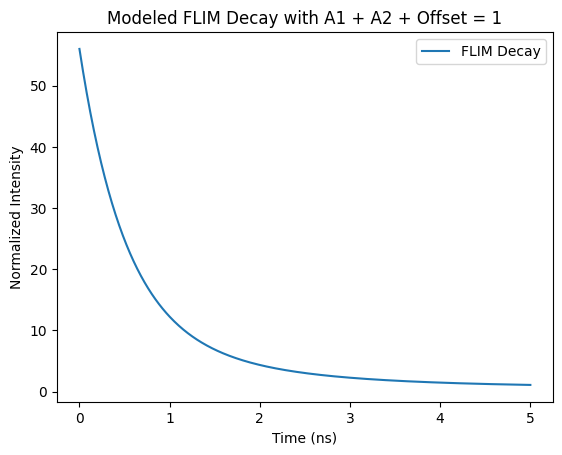

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
tau1 = 0.5  # Lifetime for component 1
tau2 = 1.5  # Lifetime for component 2

# Fractional amplitudes
a_frac = a1[0,0]  # Fractional amplitude for A1
b_frac = a2[0,0] # Fractional amplitude for A2

# Ensure offset so that A1 + A2 + offset = 1
offset = offset[0,0]

# Time array
time = np.linspace(0, 5, 500)

# Calculate the decay
decay = a_frac * np.exp(-time / tau1) + b_frac * np.exp(-time / tau2) + offset
decay = decay * 56
# Plot the decay curve
plt.plot(time, decay, label='FLIM Decay')
plt.xlabel('Time (ns)')
plt.ylabel('Normalized Intensity')
plt.title('Modeled FLIM Decay with A1 + A2 + Offset = 1')
plt.legend()
plt.show()


# **Function to generate lifetime values**

In [ ]:
def generate_lifetime(image):
    """
    Generate normalized lifetime values for the input binary image so that a1, a2, and offset sum to 1.

    Parameters:
    image (numpy.ndarray): Binary image (2D array) where non-zero values indicate regions of interest.

    Returns:
    tuple: Five 2D numpy arrays (tau1, tau2, a1, a2, offset) with the same shape as the input image.
    """
    # Ensure the input is a NumPy array
    image = np.asarray(image)

    # Get the dimensions of the input image
    m, n = image.shape

    # Generate random values for tau1 and tau2 within their initial ranges
    tau1 = np.random.uniform(0.1, 0.7, (m, n)) * image
    tau2 = np.random.uniform(1.5, 5, (m, n)) * image

    # Generate initial random values for a1, a2, and offset within the given ranges
    a1_initial = np.random.uniform(1, 450, (m, n)) * image
    a2_initial = np.random.uniform(0.1, 150, (m, n)) * image
    offset_initial = np.random.uniform(0.1, 8, (m, n)) * image

    # Calculate the total sum of a1, a2, and offset for normalization
    total_sum = a1_initial + a2_initial + offset_initial

    # Create a mask for zero-sum pixels
    zero_sum_mask = (total_sum == 0)

    # Temporarily set total_sum to 1 to avoid division by zero
    total_sum_safe = np.copy(total_sum)
    total_sum_safe[zero_sum_mask] = 1

    # Normalize a1, a2, and offset
    a1 = (a1_initial / total_sum_safe) * image
    a2 = (a2_initial / total_sum_safe) * image
    offset = (offset_initial / total_sum_safe) * image

    # Explicitly set zero-sum pixels to 0
    a1[zero_sum_mask] = 0
    a2[zero_sum_mask] = 0
    offset[zero_sum_mask] = 0

    return tau1, tau2, a1, a2, offset


**Function to generate intensity array**

In [ ]:
def generate_intensity(image):

    # Get dimensions of the input image
    m, n = image.shape

    # Generate a random matrix of intensity values within the range 50-300
    int1 = np.random.uniform(28, 800, (m, n))  # Uniform distribution

    # Multiply the random intensity matrix element-wise with the input image
    intensity = int1 * image

    return intensity


In [ ]:
irf = control/np.sum(control)

**Function to to generate Fluorescence decay**

In [ ]:
def generate_tpsfs(intensity, tau1, tau2, a1, a2, offset):
    """
    Generate time-resolved photon counts (TPSF) for each pixel based on the provided parameters.

    Parameters:
    intensity (numpy.ndarray): Intensity values (2D array).
    tau1 (numpy.ndarray): Decay lifetime for the first component.
    tau2 (numpy.ndarray): Decay lifetime for the second component.
    a1 (numpy.ndarray): Fractional amplitude for the first decay component.
    a2 (numpy.ndarray): Fractional amplitude for the second decay component.
    offset (numpy.ndarray): Baseline offset ensuring total sum to 1.

    Returns:
    numpy.ndarray: TPSF data array with decay at each time gate for each pixel.
    """
    M, N = intensity.shape
    nTG = 256
    width = 4.89e-2  # gate width 48.9 ps
    time = np.arange(0, 256, 1) * width

    # Pre-allocate memory for each TPSF voxel
    full_data0 = np.zeros((M, N, nTG))

    # Loop over all pixels spatially
    for i in range(M):
        for j in range(N):
            # Only process locations where tau1 is non-zero
            if tau1[i, j] != 0:
                # Create initial bi-exponential decay with normalized parameters
                decay = (
                    a1[i, j] * np.exp(-time / tau1[i, j]) +
                    a2[i, j] * np.exp(-time / tau2[i, j]) +
                    offset[i, j]
                )

                # Convolve IRF with exponential decay
                decay = np.convolve(decay, irf, mode='full')

                # Add random time shifts to decay
                r = np.random.random()
                if r > 0.75:
                    decay = decay[:nTG]
                elif r < 0.25:
                    rC = int(np.round(np.random.random() * 2 + 1))
                    decay = np.concatenate([np.zeros(rC), decay[:nTG - rC]])
                else:
                    rC = int(np.round(np.random.random() * 2 + 1))
                    decay = decay[rC:nTG + rC]

                # Apply intensity scaling

                decay *= intensity[i, j]

                # Add Poisson noise
                cur = np.round(np.random.poisson(decay))


                # Normalize and store the generated TPSF
                full_data0[i, j, :] = cur

    return full_data0


Visualizing Generated synthetic data

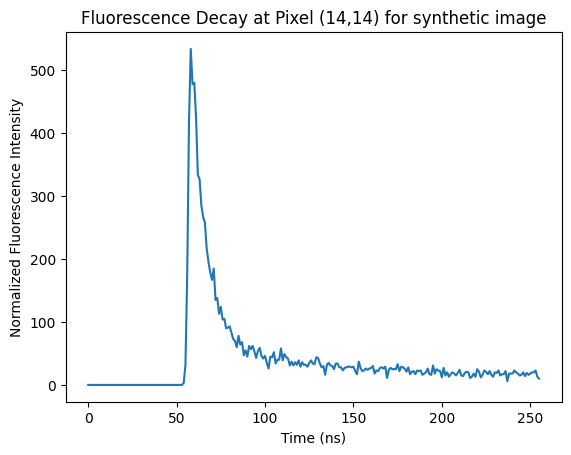

Intensity: 614.4270941804924
Tau1: 0.39845685207542314
Tau2: 4.236646798647238
A1: 0.8931988568905955
A2: 0.09274129773910764
Offset: 0.014059845370296893


In [ ]:
# Assuming sigD, I, t1, t2, rT are numpy arrays defined previously

# Plot a specific TPSF and display the parameters used for generation
xC = 14  # Python is 0-based indexing
yC = 14
plt.figure()
plt.plot(sigD[yC, xC, :])
plt.xlabel('Time (ns)')
plt.ylabel('Normalized Fluorescence Intensity')
plt.title(f'Fluorescence Decay at Pixel ({yC},{xC}) for synthetic image')

plt.show()
print(f"Intensity: {I[yC, xC]}")
print(f"Tau1: {t1[yC, xC]}")
print(f"Tau2: {t2[yC, xC]}")
print(f"A1: {a1[yC, xC]}")
print(f"A2: {a2[yC, xC]}")
print(f"Offset: {offset[yC, xC]}")



generate SYnthetic FLIM Image

In [ ]:

N_total = 500
k = 1

while k <= N_total:  # Use <= to ensure N_total images are processed
    # Randomly select an image
    rand_idx = np.random.randint(0, first_array.shape[2])
    im_binary = first_array[:, :, rand_idx]

    # Check if the image has a pixel sum above 280
    if np.sum(im_binary) >= 250:
        # Convert the image to PIL Image
        img = Image.fromarray(im_binary.astype('uint8'))  # Convert to PIL Image

        # Randomly select a rotation angle
        angle = random.choice([90, 23, 76, 82, 231, 67, 260, 104, 56, 37, 301, 201, 60, 30, 45])
        img_rotated = img.rotate(angle)

        # Randomly decide whether to flip the image
        if random.choice([True, False]):  # 50% chance
            img_rotated = ImageOps.mirror(img_rotated)  # Flip the image

        # Convert the PIL image back to a numpy array if your functions expect numpy array input
        # This step is crucial if the augmentation changes need to be reflected in the data passed to subsequent functions
        im_binary = np.array(img_rotated)

        # Generate intensity and lifetime maps (your functions should be defined to handle im_augmented)
        # Assuming generate_intensity, generate_lifetime, generate_tpsfs functions are properly defined to accept the augmented image data
        inten = generate_intensity(im_binary)
        tau1, tau2, a1, a2, offset = generate_lifetime(im_binary)
        data = generate_tpsfs(inten, tau1, tau2, a1, a2, offset)


        m, n = im_binary.shape

        t1 = tau1
        t2 = tau2
        a1 = a1
        a2 = a2
        offset = offset


        # Save the data
        sigD = data
        I = inten * im_binary

        # # Assign path along with file name
        pathN = '/content/drive/MyDrive/train'
        if not os.path.exists(pathN):
            os.makedirs(pathN)  # Create the directory if it doesn't exist

        filenm = os.path.join(pathN, f'a_{str(k).zfill(5)}_1')

        # Save the data
        np.savez(f"{filenm}.npz", sigD=sigD, I=I, t1=t1, t2=t2, a1=a1, a2=a2, offset=offset)

        k += 1  # Increment only if the image meets the condition and has been processed


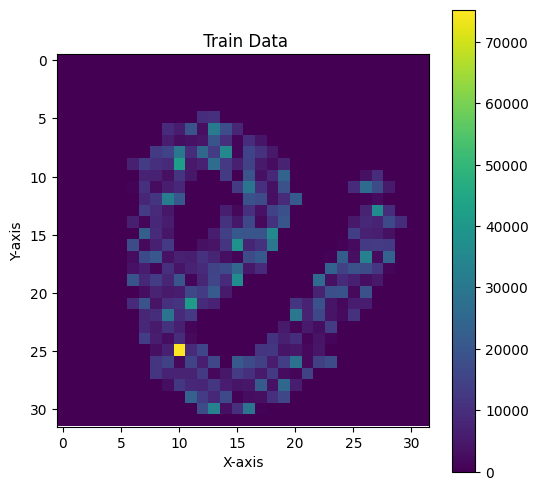

In [ ]:
# Sum the intensities along the depth axis to create a 2D projection
intensity = sigD.sum(axis=2)

# Plot the normalized intensity projection
plt.figure(figsize=(6, 6))
plt.imshow(intensity, cmap='viridis')
plt.colorbar()
plt.title(' Train Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()
